In [1]:
import sys
sys.path.append('/beegfs/desy/user/akorol/projects/point-cloud-diffusion')

import numpy as np
import matplotlib.pyplot as plt
import importlib
import pickle
from scipy.stats import wasserstein_distance

import utils.metrics as metrics
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import random

In [2]:
# seed everything for reproducibility
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

In [3]:
pickle_path = '/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/metrics/'

dict_real = pickle.load(open(pickle_path + 'merge_dict_10-90GeV_500000_g4.pickle', 'rb'))
dict_ddpm = pickle.load(open(pickle_path + 'merge_dict_10-90GeV_500000_ddpm.pickle', 'rb'))
dict_edm = pickle.load(open(pickle_path + 'merge_dict_10-90GeV_500000_edm.pickle', 'rb'))
dict_cm = pickle.load(open(pickle_path + 'merge_dict_10-90GeV_500000_cm.pickle', 'rb'))

print(dict_cm.keys())


dict_keys(['e_sum', 'hits', 'occ', 'hits_noThreshold', 'binned_layer_e', 'binned_radial_e', 'incident_energy', 'cog_x', 'cog_y', 'cog_z'])


In [4]:
# combine observables in a single array

obs_real = metrics.get_event_observables_from_dict(dict_real)
obs_ddpm = metrics.get_event_observables_from_dict(dict_ddpm)
obs_edm = metrics.get_event_observables_from_dict(dict_edm)
obs_cm = metrics.get_event_observables_from_dict(dict_cm)

# shuffle the data
obs_real = obs_real[np.random.permutation(len(obs_real))]
obs_ddpm = obs_ddpm[np.random.permutation(len(obs_ddpm))]
obs_edm = obs_edm[np.random.permutation(len(obs_edm))]
obs_cm = obs_cm[np.random.permutation(len(obs_cm))]

print(obs_real.shape)

mean_real, std_real = np.mean(obs_real, axis=0).reshape(1,-1), np.std(obs_real, axis=0).reshape(1,-1)

print(mean_real.shape)

(500000, 26)
(1, 26)


In [5]:
# standardise the data
def standardize(ary, mean, std):
    return (ary - mean) / std

obs_std_real = standardize(obs_real, mean=mean_real, std=std_real)
obs_std_ddpm = standardize(obs_ddpm, mean=mean_real, std=std_real)
obs_std_edm = standardize(obs_edm, mean=mean_real, std=std_real)
obs_std_cm = standardize(obs_cm, mean=mean_real, std=std_real)

In [6]:
# array without hits
obs_std_real_woutHits = np.concatenate([obs_std_real[:,0:5], obs_std_real[:,6:]], axis=1)
obs_std_ddpm_woutHits = np.concatenate([obs_std_ddpm[:,0:5], obs_std_ddpm[:,6:]], axis=1)
obs_std_edm_woutHits = np.concatenate([obs_std_edm[:,0:5], obs_std_edm[:,6:]], axis=1)
obs_std_cm_woutHits = np.concatenate([obs_std_cm[:,0:5], obs_std_cm[:,6:]], axis=1)

print(obs_std_real_woutHits.shape)

(500000, 25)


# Low lvl clasifier

In [7]:
device = torch.device('cuda')


class Discriminator(nn.Module):
    def __init__(self, num_features):
        super(Discriminator, self).__init__()

        
        self.Classifier = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.LeakyReLU(0.2),
            
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = self.Classifier(x)
        return x


In [8]:
mode = 'real_VS_ddpm' # choices=['real_VS_ddpm', 'real_VS_edm', 'real_VS_cm', 'all']

def get_dataloader(features_real, features_fake, batch_size=256, shuffle=True, num_workers=4):
    
    labels_real = np.ones(len(features_real))
    labels_fake = np.zeros(len(features_fake))
    
    dataset = list(
        zip(
            np.concatenate((features_real, features_fake)), 
            np.concatenate((labels_real, labels_fake))
        )
    )
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size, 
        shuffle=shuffle, 
        num_workers=num_workers
    )
    
    return dataloader

In [9]:
def train(mode):

    clasifier = Discriminator(num_features=25)
    clasifier.to(device)

    if mode == 'real_VS_ddpm':
        train_dataloader = get_dataloader(
            obs_std_real_woutHits[:350000],
            obs_std_ddpm_woutHits[:350000]
        )
        test_dataloader = get_dataloader(
            obs_std_real_woutHits[-75000:],
            obs_std_ddpm_woutHits[-75000:]
        )
        validation_dataloader = get_dataloader(
            obs_std_real_woutHits[350000:425000],
            obs_std_ddpm_woutHits[350000:425000]
        )
    elif mode == 'real_VS_edm':
        train_dataloader = get_dataloader(
            obs_std_real_woutHits[:350000],
            obs_std_edm_woutHits[:350000]
        )
        test_dataloader = get_dataloader(
            obs_std_real_woutHits[-75000:],
            obs_std_edm_woutHits[-75000:]
        )
        validation_dataloader = get_dataloader(
            obs_std_real_woutHits[350000:425000],
            obs_std_edm_woutHits[350000:425000]
        )
    elif mode == 'real_VS_cm':
        train_dataloader = get_dataloader(
            obs_std_real_woutHits[:350000],
            obs_std_cm_woutHits[:350000]
        )
        test_dataloader = get_dataloader(
            obs_std_real_woutHits[-75000:],
            obs_std_cm_woutHits[-75000:]
        )
        validation_dataloader = get_dataloader(
            obs_std_real_woutHits[350000:425000],
            obs_std_cm_woutHits[350000:425000]
        )
    elif mode == 'all':
        pass

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(clasifier.parameters(), lr=0.001)

    num_epochs = 10

    test_acccs = []
    best_loss = 1e10
    for epoch in range(num_epochs):
        clasifier.train()
        for i, (features, labels) in enumerate(train_dataloader):
            features = features.to(device).float()
            labels = labels.to(device).float()
            
            outputs = clasifier(features).view(-1)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
            if (i+1) % 1000 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, i+1, len(train_dataloader), loss.item()
                ))
                clasifier.eval()
                with torch.no_grad():
                    correct = 0
                    total = 0
                    val_loss = 0
                    for features, labels in validation_dataloader:
                        features = features.to(device).float()
                        labels = labels.to(device).float()
                        
                        outputs = clasifier(features).view(-1)

                        val_loss += criterion(outputs, labels).item()

                        predicted = torch.round(torch.sigmoid(outputs))
                        
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                    val_loss /= len(validation_dataloader)

                    if val_loss < best_loss:
                        best_loss = val_loss
                        torch.save(clasifier.state_dict(), f'clasifier_best_val_loss_{mode}.pth')

                    print('Test Accuracy of the model on the {} test samples: {} %'.format(total, 100 * correct / total))
                    test_acccs.append(100 * correct / total)
                clasifier.train()
    print('Finished Training')
    print('Best val loss: {}'.format(best_loss))

    print('predicting...')
    clasifier.load_state_dict(torch.load(f'clasifier_best_val_loss_{mode}.pth'))

    # get AUROC
    clasifier.eval()
    with torch.no_grad():
        predistions = []
        labels = []
        for features, label in test_dataloader:
            features = features.to(device).float()

            outputs = clasifier(features).view(-1)
            predicted = torch.sigmoid(outputs)

            predistions.append(predicted.cpu().numpy())
            labels.append(label.numpy())

    predistions = np.concatenate(predistions)
    labels = np.concatenate(labels)

    auc_score = roc_auc_score(labels, predistions)

    return test_acccs, auc_score

In [10]:
auc_scres = []
for mode in ['real_VS_ddpm', 'real_VS_edm', 'real_VS_cm']:
    test_acccs, auc_score = train(mode)
    auc_scres.append(auc_score)
    np.save('test_acccs_{}.npy'.format(mode), test_acccs)

Epoch [1/10], Step [1000/2735], Loss: 0.0228
Test Accuracy of the model on the 150000 test samples: 99.25333333333333 %
Epoch [1/10], Step [2000/2735], Loss: 0.0139
Test Accuracy of the model on the 150000 test samples: 99.60466666666666 %
Epoch [2/10], Step [1000/2735], Loss: 0.0119
Test Accuracy of the model on the 150000 test samples: 99.70866666666667 %
Epoch [2/10], Step [2000/2735], Loss: 0.0085
Test Accuracy of the model on the 150000 test samples: 99.79866666666666 %
Epoch [3/10], Step [1000/2735], Loss: 0.0016
Test Accuracy of the model on the 150000 test samples: 99.75466666666667 %
Epoch [3/10], Step [2000/2735], Loss: 0.0040
Test Accuracy of the model on the 150000 test samples: 99.798 %
Epoch [4/10], Step [1000/2735], Loss: 0.0037
Test Accuracy of the model on the 150000 test samples: 99.826 %
Epoch [4/10], Step [2000/2735], Loss: 0.0014
Test Accuracy of the model on the 150000 test samples: 99.77333333333333 %
Epoch [5/10], Step [1000/2735], Loss: 0.0014
Test Accuracy of 

real_VS_ddpm test: auc=0.9999704679999999
real_VS_edm test: auc=0.9267227592888889
real_VS_cm test: auc=0.9230983230222223


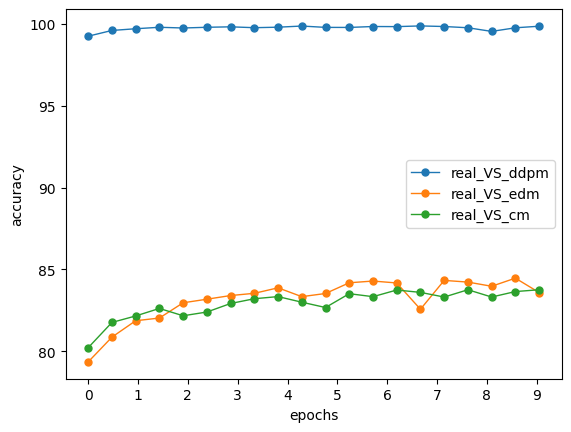

In [11]:
for i, mode in enumerate(['real_VS_ddpm', 'real_VS_edm', 'real_VS_cm']):
    print(f"{mode} test: auc={auc_scres[i]}")
    test_acccs = np.load('test_acccs_{}.npy'.format(mode))
    plt.plot(test_acccs, label=mode, marker='o', lw=1, ms=5)
plt.xticks(np.arange(0, len(test_acccs), 2.1), np.arange(10))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()